<h1>EmpathNet: the New CherryStems algorithm</h1>

This is the new Empath musical audio generation with deep learning models. The baseline model is using the reference of an amazing blog post by https://www.analyticsvidhya.com/blog/2020/01/how-to-perform-automatic-music-generation/

<h2>Step 1: Import libraries</h2>

In [3]:
#library for understanding music
from music21 import *

<h2>Step 2: Read Musical Files</h2>

Define a function for reading the MIDI files, it returns the array of notes and choids present in the musical file.

In [4]:
#defining function to read MIDI files
def read_midi(file):
    
    print("Loading Music File:",file)
    
    notes=[]
    notes_to_parse = None
    
    #parsing a midi file
    midi = converter.parse(file)
  
    #grouping based on different instruments
    s2 = instrument.partitionByInstrument(midi)

    #Looping over all the instruments
    for part in s2.parts:
    
        #select elements of only piano
        if 'Piano' in str(part): 
        
            notes_to_parse = part.recurse() 
      
            #finding whether a particular element is note or a chord
            for element in notes_to_parse:
                
                #note
                if isinstance(element, note.Note):
                    notes.append(str(element.pitch))
                
                #chord
                elif isinstance(element, chord.Chord):
                    notes.append('.'.join(str(n) for n in element.normalOrder))

    return np.array(notes)

<h2>Step 3: Load the MIDI files into our environment</h2>

In [5]:
#for listing down the file names
import os

#Array Processing
import numpy as np

#specify the path
path='schubert/'

#read all the filenames
files=[i for i in os.listdir(path) if i.endswith(".mid")]

#reading each midi file
notes_array = np.array([read_midi(path+i) for i in files])

Loading Music File: schubert/schumm-1.mid
Loading Music File: schubert/schumm-2.mid
Loading Music File: schubert/schub_d960_4.mid
Loading Music File: schubert/schumm-3.mid
Loading Music File: schubert/schub_d960_1.mid
Loading Music File: schubert/schumm-6.mid
Loading Music File: schubert/schumm-4.mid
Loading Music File: schubert/schub_d960_2.mid
Loading Music File: schubert/schub_d960_3.mid
Loading Music File: schubert/schumm-5.mid
Loading Music File: schubert/schuim-4.mid
Loading Music File: schubert/schuim-1.mid
Loading Music File: schubert/schuim-3.mid
Loading Music File: schubert/schuim-2.mid
Loading Music File: schubert/schubert_D850_4.mid
Loading Music File: schubert/schubert_D935_4.mid
Loading Music File: schubert/schub_d760_4.mid
Loading Music File: schubert/schubert_D850_1.mid
Loading Music File: schubert/schubert_D935_1.mid
Loading Music File: schubert/schub_d760_1.mid
Loading Music File: schubert/schubert_D850_2.mid
Loading Music File: schubert/schub_d760_3.mid
Loading Music

<h2>Step 4: Understand the data</h2>

In [9]:
#converting 2D array into 1D array
notes_ = [element for note_ in notes_array for element in note_]

#No. of unique notes
unique_notes = list(set(notes_))
print(len(unique_notes))

304


<h4>Now see the distribution of the notes</h4>

(array([187.,  41.,  26.,  11.,   6.,   9.,  12.,   6.,   3.,   3.]),
 array([1.0000e+00, 1.4790e+02, 2.9480e+02, 4.4170e+02, 5.8860e+02,
        7.3550e+02, 8.8240e+02, 1.0293e+03, 1.1762e+03, 1.3231e+03,
        1.4700e+03]),
 <a list of 10 Patch objects>)

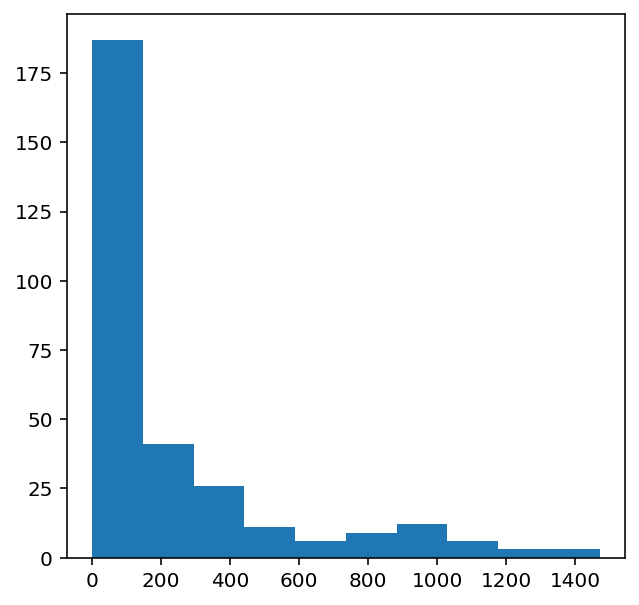

In [21]:
#importing library
from collections import Counter

#computing frequency of each note
#the use of the word 'freq' means the occurence frequency of notes not the musical frequency
freq = dict(Counter(notes_))

#library for visualiation
import matplotlib.pyplot as plt

#consider only the frequencies
no=[count for _,count in freq.items()]

#set the figure size
plt.figure(figsize=(5,5))

#plot
plt.hist(no)

From the above plot, we can infer that most of the notes have a very low frequency. So, let us keep the top frequent notes and ignore the low-frequency ones. Here, I am defining the threshold as 50. Nevertheless, the parameter can be changed.

In [22]:
frequent_notes = [note_ for note_, count in freq.items() if count>=50]
print(len(frequent_notes))

167


<h2>Step 5: Prepare the data</h2>

In [24]:
## prepare new musical files which contain only the top frequent notes

new_music=[]

for notes in notes_array:
    temp=[]
    for note_ in notes:
        if note_ in frequent_notes:
            temp.append(note_)            
    new_music.append(temp)
    
new_music = np.array(new_music)

In [25]:
## Preparing the input and output sequences as mentioned in the article:
no_of_timesteps = 32
x = []
y = []

for note_ in new_music:
    for i in range(0, len(note_) - no_of_timesteps, 1):
        
        #preparing input and output sequences
        input_ = note_[i:i + no_of_timesteps]
        output = note_[i + no_of_timesteps]
        
        x.append(input_)
        y.append(output)
        
x=np.array(x)
y=np.array(y)

In [26]:
## assign a unique integer to every note:
unique_x = list(set(x.ravel()))
x_note_to_int = dict((note_, number) for number, note_ in enumerate(unique_x))

In [27]:
# preparing input sequences
x_seq=[]
for i in x:
    temp=[]
    for j in i:
        #assigning unique integer to every note
        temp.append(x_note_to_int[j])
    x_seq.append(temp)
    
x_seq = np.array(x_seq)

In [28]:
## prepare output sequences
unique_y = list(set(y))
y_note_to_int = dict((note_, number) for number, note_ in enumerate(unique_y)) 
y_seq=np.array([y_note_to_int[i] for i in y])

In [29]:
## 80% of the data for training and 20% for testing
from sklearn.model_selection import train_test_split
x_tr, x_val, y_tr, y_val = train_test_split(x_seq,y_seq,test_size=0.2,random_state=0)

<h2>Step 6: Build Model</h2>

<h4>WaveNet model</h4>

In [103]:
from keras.layers import *
from keras.models import *
from keras.callbacks import *
import keras.backend as K

K.clear_session()
model = Sequential()
    
#embedding layer
model.add(Embedding(len(unique_x), 100, input_length=32, trainable=True)) 

model.add(Conv1D(64,3, padding='causal', activation='relu'))
model.add(Dropout(0.2))
model.add(MaxPool1D(2))
    
model.add(Conv1D(128,3,activation='relu',dilation_rate=2,padding='causal'))
model.add(Dropout(0.2))
model.add(MaxPool1D(2))

model.add(Conv1D(256,3,activation='relu',dilation_rate=4,padding='causal'))
model.add(Dropout(0.2))
model.add(MaxPool1D(2))
          
#model.add(Conv1D(256,5,activation='relu'))    
model.add(GlobalMaxPool1D())
    
model.add(Dense(256, activation='relu'))
model.add(Dense(len(unique_y), activation='softmax'))
    
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam')

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 32, 100)           16700     
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 32, 64)            19264     
_________________________________________________________________
dropout_1 (Dropout)          (None, 32, 64)            0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 16, 64)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 16, 128)           24704     
_________________________________________________________________
dropout_2 (Dropout)          (None, 16, 128)           0         
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 8, 128)            0         
__________

<h4>LSTM model</h4>

In [104]:
model2 = Sequential()
model2.add(LSTM(128,return_sequences=True))
model2.add(LSTM(128))
model2.add(Dense(256))
model2.add(Activation('relu'))
model2.add(Dense(256))
model2.add(Activation('softmax'))
model2.compile(loss='sparse_categorical_crossentropy', optimizer='adam')

<h4>Define the callback to save the best model during training</h4>

In [105]:
mc=ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', save_best_only=True,verbose=1)

<h2>Step 7: Training</h2>

In [106]:
#loading best model from previous training if available
from keras.models import load_model

try:
    previous_model = load_model('best_model.h5')
    model = previous_model
    print("loaded from last time")
except ImportError:
    print("starting a new model")
    pass

loaded from last time


In [ ]:
#training wavenet model
history = model.fit(np.array(x_tr),
                    np.array(y_tr),
                    batch_size=128,
                    epochs=3000, 
                    validation_data=(np.array(x_val),
                                     np.array(y_val)),
                    verbose=1, 
                    callbacks=[mc])

Train on 51530 samples, validate on 12883 samples
Epoch 1/3000
51530/51530 [==============================] - 13s 261us/step - loss: 1.8033 - val_loss: 2.5675

Epoch 00001: val_loss improved from inf to 2.56749, saving model to best_model.h5
Epoch 2/3000
51530/51530 [==============================] - 13s 260us/step - loss: 1.8079 - val_loss: 2.5733

Epoch 00002: val_loss did not improve from 2.56749
Epoch 3/3000
51530/51530 [==============================] - 14s 280us/step - loss: 1.8131 - val_loss: 2.5718

Epoch 00003: val_loss did not improve from 2.56749
Epoch 4/3000
51530/51530 [==============================] - 15s 293us/step - loss: 1.8072 - val_loss: 2.5720

Epoch 00004: val_loss did not improve from 2.56749
Epoch 5/3000
51530/51530 [==============================] - 15s 299us/step - loss: 1.8073 - val_loss: 2.5716

Epoch 00005: val_loss did not improve from 2.56749
Epoch 6/3000
51530/51530 [==============================] - 17s 320us/step - loss: 1.8074 - val_loss: 2.5692

Epoc

51530/51530 [==============================] - 16s 311us/step - loss: 1.8029 - val_loss: 2.5726

Epoch 00050: val_loss did not improve from 2.55497
Epoch 51/3000
51530/51530 [==============================] - 16s 302us/step - loss: 1.8014 - val_loss: 2.5749

Epoch 00051: val_loss did not improve from 2.55497
Epoch 52/3000
51530/51530 [==============================] - 17s 339us/step - loss: 1.8071 - val_loss: 2.5725

Epoch 00052: val_loss did not improve from 2.55497
Epoch 53/3000
51530/51530 [==============================] - 17s 334us/step - loss: 1.8042 - val_loss: 2.5616

Epoch 00053: val_loss did not improve from 2.55497
Epoch 54/3000
51530/51530 [==============================] - 16s 309us/step - loss: 1.7965 - val_loss: 2.5793

Epoch 00054: val_loss did not improve from 2.55497
Epoch 55/3000
51530/51530 [==============================] - 17s 339us/step - loss: 1.8029 - val_loss: 2.5729

Epoch 00055: val_loss did not improve from 2.55497
Epoch 56/3000
51530/51530 [===============


Epoch 00100: val_loss did not improve from 2.55497
Epoch 101/3000
51530/51530 [==============================] - 16s 319us/step - loss: 1.8053 - val_loss: 2.5704

Epoch 00101: val_loss did not improve from 2.55497
Epoch 102/3000
51530/51530 [==============================] - 16s 319us/step - loss: 1.8111 - val_loss: 2.5811

Epoch 00102: val_loss did not improve from 2.55497
Epoch 103/3000
51530/51530 [==============================] - 16s 304us/step - loss: 1.8024 - val_loss: 2.5673

Epoch 00103: val_loss did not improve from 2.55497
Epoch 104/3000
51530/51530 [==============================] - 15s 299us/step - loss: 1.7921 - val_loss: 2.5718

Epoch 00104: val_loss did not improve from 2.55497
Epoch 105/3000
51530/51530 [==============================] - 15s 299us/step - loss: 1.8014 - val_loss: 2.5727

Epoch 00105: val_loss did not improve from 2.55497
Epoch 106/3000
51530/51530 [==============================] - 15s 297us/step - loss: 1.8092 - val_loss: 2.5727

Epoch 00106: val_loss

51530/51530 [==============================] - 15s 298us/step - loss: 1.7932 - val_loss: 2.5616

Epoch 00150: val_loss did not improve from 2.54449
Epoch 151/3000
51530/51530 [==============================] - 15s 299us/step - loss: 1.7971 - val_loss: 2.5725

Epoch 00151: val_loss did not improve from 2.54449
Epoch 152/3000
51530/51530 [==============================] - 15s 300us/step - loss: 1.7913 - val_loss: 2.5686

Epoch 00152: val_loss did not improve from 2.54449
Epoch 153/3000
51530/51530 [==============================] - 15s 297us/step - loss: 1.7991 - val_loss: 2.5654

Epoch 00153: val_loss did not improve from 2.54449
Epoch 154/3000
51530/51530 [==============================] - 15s 300us/step - loss: 1.8009 - val_loss: 2.5820

Epoch 00154: val_loss did not improve from 2.54449
Epoch 155/3000
51530/51530 [==============================] - 15s 300us/step - loss: 1.7936 - val_loss: 2.5778

Epoch 00155: val_loss did not improve from 2.54449
Epoch 156/3000
51530/51530 [=========

51530/51530 [==============================] - 16s 320us/step - loss: 1.7973 - val_loss: 2.5652

Epoch 00200: val_loss did not improve from 2.54449
Epoch 201/3000
51530/51530 [==============================] - 16s 316us/step - loss: 1.7950 - val_loss: 2.5671

Epoch 00201: val_loss did not improve from 2.54449
Epoch 202/3000
51530/51530 [==============================] - 17s 324us/step - loss: 1.7960 - val_loss: 2.5860

Epoch 00202: val_loss did not improve from 2.54449
Epoch 203/3000
51530/51530 [==============================] - 17s 323us/step - loss: 1.8018 - val_loss: 2.5773

Epoch 00203: val_loss did not improve from 2.54449
Epoch 204/3000
51530/51530 [==============================] - 17s 326us/step - loss: 1.7993 - val_loss: 2.5800

Epoch 00204: val_loss did not improve from 2.54449
Epoch 205/3000
51530/51530 [==============================] - 17s 327us/step - loss: 1.7996 - val_loss: 2.5762

Epoch 00205: val_loss did not improve from 2.54449
Epoch 206/3000
51530/51530 [=========

51530/51530 [==============================] - 17s 323us/step - loss: 1.8014 - val_loss: 2.5840

Epoch 00250: val_loss did not improve from 2.54449
Epoch 251/3000
51530/51530 [==============================] - 16s 319us/step - loss: 1.7882 - val_loss: 2.5695

Epoch 00251: val_loss did not improve from 2.54449
Epoch 252/3000
51530/51530 [==============================] - 16s 318us/step - loss: 1.7888 - val_loss: 2.5642

Epoch 00252: val_loss did not improve from 2.54449
Epoch 253/3000
51530/51530 [==============================] - 16s 317us/step - loss: 1.8015 - val_loss: 2.5816

Epoch 00253: val_loss did not improve from 2.54449
Epoch 254/3000
51530/51530 [==============================] - 16s 318us/step - loss: 1.7911 - val_loss: 2.5758

Epoch 00254: val_loss did not improve from 2.54449
Epoch 255/3000
51530/51530 [==============================] - 16s 313us/step - loss: 1.8009 - val_loss: 2.5660

Epoch 00255: val_loss did not improve from 2.54449
Epoch 256/3000
51530/51530 [=========

51530/51530 [==============================] - 17s 336us/step - loss: 1.7978 - val_loss: 2.5777

Epoch 00300: val_loss did not improve from 2.54449
Epoch 301/3000
51530/51530 [==============================] - 20s 386us/step - loss: 1.8081 - val_loss: 2.5883

Epoch 00301: val_loss did not improve from 2.54449
Epoch 302/3000
51530/51530 [==============================] - 16s 308us/step - loss: 1.7914 - val_loss: 2.5679

Epoch 00302: val_loss did not improve from 2.54449
Epoch 303/3000
51530/51530 [==============================] - 16s 304us/step - loss: 1.7949 - val_loss: 2.5674

Epoch 00303: val_loss did not improve from 2.54449
Epoch 304/3000
51530/51530 [==============================] - 15s 300us/step - loss: 1.8031 - val_loss: 2.5868

Epoch 00304: val_loss did not improve from 2.54449
Epoch 305/3000
51530/51530 [==============================] - 15s 295us/step - loss: 1.7864 - val_loss: 2.5970

Epoch 00305: val_loss did not improve from 2.54449
Epoch 306/3000
51530/51530 [=========

51530/51530 [==============================] - 15s 285us/step - loss: 1.7943 - val_loss: 2.5733

Epoch 00350: val_loss did not improve from 2.54449
Epoch 351/3000
51530/51530 [==============================] - 15s 286us/step - loss: 1.7941 - val_loss: 2.5661

Epoch 00351: val_loss did not improve from 2.54449
Epoch 352/3000
51530/51530 [==============================] - 15s 283us/step - loss: 1.7848 - val_loss: 2.5677

Epoch 00352: val_loss did not improve from 2.54449
Epoch 353/3000
51530/51530 [==============================] - 15s 284us/step - loss: 1.7978 - val_loss: 2.5739

Epoch 00353: val_loss did not improve from 2.54449
Epoch 354/3000
51530/51530 [==============================] - 14s 281us/step - loss: 1.7919 - val_loss: 2.5742

Epoch 00354: val_loss did not improve from 2.54449
Epoch 355/3000
51530/51530 [==============================] - 15s 282us/step - loss: 1.7883 - val_loss: 2.5711

Epoch 00355: val_loss did not improve from 2.54449
Epoch 356/3000
51530/51530 [=========

51530/51530 [==============================] - 15s 299us/step - loss: 1.8029 - val_loss: 2.5774

Epoch 00400: val_loss did not improve from 2.54449
Epoch 401/3000
51530/51530 [==============================] - 15s 298us/step - loss: 1.7870 - val_loss: 2.5800

Epoch 00401: val_loss did not improve from 2.54449
Epoch 402/3000
51530/51530 [==============================] - 15s 297us/step - loss: 1.7961 - val_loss: 2.5787

Epoch 00402: val_loss did not improve from 2.54449
Epoch 403/3000
51530/51530 [==============================] - 15s 295us/step - loss: 1.7998 - val_loss: 2.5744

Epoch 00403: val_loss did not improve from 2.54449
Epoch 404/3000
51530/51530 [==============================] - 16s 301us/step - loss: 1.7956 - val_loss: 2.5800

Epoch 00404: val_loss did not improve from 2.54449
Epoch 405/3000
51530/51530 [==============================] - 15s 298us/step - loss: 1.7938 - val_loss: 2.5775

Epoch 00405: val_loss did not improve from 2.54449
Epoch 406/3000
51530/51530 [=========

51530/51530 [==============================] - 15s 289us/step - loss: 1.7877 - val_loss: 2.5866

Epoch 00450: val_loss did not improve from 2.54449
Epoch 451/3000
51530/51530 [==============================] - 15s 294us/step - loss: 1.8045 - val_loss: 2.5784

Epoch 00451: val_loss did not improve from 2.54449
Epoch 452/3000
51530/51530 [==============================] - 15s 291us/step - loss: 1.7916 - val_loss: 2.5745

Epoch 00452: val_loss did not improve from 2.54449
Epoch 453/3000
51530/51530 [==============================] - 15s 293us/step - loss: 1.7932 - val_loss: 2.5812

Epoch 00453: val_loss did not improve from 2.54449
Epoch 454/3000
51530/51530 [==============================] - 15s 293us/step - loss: 1.7900 - val_loss: 2.5801

Epoch 00454: val_loss did not improve from 2.54449
Epoch 455/3000
51530/51530 [==============================] - 15s 294us/step - loss: 1.7925 - val_loss: 2.5727

Epoch 00455: val_loss did not improve from 2.54449
Epoch 456/3000
51530/51530 [=========

51530/51530 [==============================] - 15s 288us/step - loss: 1.8000 - val_loss: 2.5879

Epoch 00500: val_loss did not improve from 2.54449
Epoch 501/3000
51530/51530 [==============================] - 15s 294us/step - loss: 1.7936 - val_loss: 2.5700

Epoch 00501: val_loss did not improve from 2.54449
Epoch 502/3000
51530/51530 [==============================] - 15s 293us/step - loss: 1.7948 - val_loss: 2.5914

Epoch 00502: val_loss did not improve from 2.54449
Epoch 503/3000
51530/51530 [==============================] - 15s 296us/step - loss: 1.7864 - val_loss: 2.5730

Epoch 00503: val_loss did not improve from 2.54449
Epoch 504/3000
51530/51530 [==============================] - 15s 292us/step - loss: 1.7851 - val_loss: 2.5633

Epoch 00504: val_loss did not improve from 2.54449
Epoch 505/3000
51530/51530 [==============================] - 15s 294us/step - loss: 1.7856 - val_loss: 2.5702

Epoch 00505: val_loss did not improve from 2.54449
Epoch 506/3000
51530/51530 [=========

51530/51530 [==============================] - 16s 310us/step - loss: 1.7879 - val_loss: 2.5962

Epoch 00550: val_loss did not improve from 2.54449
Epoch 551/3000
51530/51530 [==============================] - 16s 309us/step - loss: 1.7937 - val_loss: 2.5844

Epoch 00551: val_loss did not improve from 2.54449
Epoch 552/3000
51530/51530 [==============================] - 16s 309us/step - loss: 1.7903 - val_loss: 2.5802

Epoch 00552: val_loss did not improve from 2.54449
Epoch 553/3000
51530/51530 [==============================] - 16s 308us/step - loss: 1.7966 - val_loss: 2.5694

Epoch 00553: val_loss did not improve from 2.54449
Epoch 554/3000
51530/51530 [==============================] - 17s 323us/step - loss: 1.7909 - val_loss: 2.5826

Epoch 00554: val_loss did not improve from 2.54449
Epoch 555/3000
51530/51530 [==============================] - 17s 329us/step - loss: 1.7898 - val_loss: 2.5796

Epoch 00555: val_loss did not improve from 2.54449
Epoch 556/3000
51530/51530 [=========

51530/51530 [==============================] - 17s 329us/step - loss: 1.7888 - val_loss: 2.5845

Epoch 00600: val_loss did not improve from 2.54449
Epoch 601/3000
51530/51530 [==============================] - 17s 326us/step - loss: 1.7828 - val_loss: 2.5802

Epoch 00601: val_loss did not improve from 2.54449
Epoch 602/3000
51530/51530 [==============================] - 17s 331us/step - loss: 1.7949 - val_loss: 2.6023

Epoch 00602: val_loss did not improve from 2.54449
Epoch 603/3000
51530/51530 [==============================] - 17s 332us/step - loss: 1.8051 - val_loss: 2.5931

Epoch 00603: val_loss did not improve from 2.54449
Epoch 604/3000
51530/51530 [==============================] - 17s 334us/step - loss: 1.7927 - val_loss: 2.5859

Epoch 00604: val_loss did not improve from 2.54449
Epoch 605/3000
51530/51530 [==============================] - 17s 331us/step - loss: 1.7889 - val_loss: 2.5723

Epoch 00605: val_loss did not improve from 2.54449
Epoch 606/3000
51530/51530 [=========

51530/51530 [==============================] - 17s 326us/step - loss: 1.8020 - val_loss: 2.5790

Epoch 00650: val_loss did not improve from 2.54449
Epoch 651/3000
51530/51530 [==============================] - 17s 329us/step - loss: 1.7826 - val_loss: 2.5906

Epoch 00651: val_loss did not improve from 2.54449
Epoch 652/3000
51530/51530 [==============================] - 16s 305us/step - loss: 1.7875 - val_loss: 2.5828

Epoch 00652: val_loss did not improve from 2.54449
Epoch 653/3000
51530/51530 [==============================] - 16s 305us/step - loss: 1.7969 - val_loss: 2.5804

Epoch 00653: val_loss did not improve from 2.54449
Epoch 654/3000
51530/51530 [==============================] - 16s 310us/step - loss: 1.7820 - val_loss: 2.5791

Epoch 00654: val_loss did not improve from 2.54449
Epoch 655/3000
51530/51530 [==============================] - 16s 306us/step - loss: 1.7905 - val_loss: 2.5827

Epoch 00655: val_loss did not improve from 2.54449
Epoch 656/3000
51530/51530 [=========

51530/51530 [==============================] - 16s 303us/step - loss: 1.8042 - val_loss: 2.5743

Epoch 00700: val_loss did not improve from 2.54449
Epoch 701/3000
51530/51530 [==============================] - 16s 306us/step - loss: 1.7844 - val_loss: 2.5890

Epoch 00701: val_loss did not improve from 2.54449
Epoch 702/3000
51530/51530 [==============================] - 16s 303us/step - loss: 1.7891 - val_loss: 2.5752

Epoch 00702: val_loss did not improve from 2.54449
Epoch 703/3000
51530/51530 [==============================] - 16s 303us/step - loss: 1.7928 - val_loss: 2.5935

Epoch 00703: val_loss did not improve from 2.54449
Epoch 704/3000
51530/51530 [==============================] - 15s 299us/step - loss: 1.7942 - val_loss: 2.5792

Epoch 00704: val_loss did not improve from 2.54449
Epoch 705/3000
51530/51530 [==============================] - 16s 311us/step - loss: 1.7757 - val_loss: 2.5637

Epoch 00705: val_loss did not improve from 2.54449
Epoch 706/3000
51530/51530 [=========

51530/51530 [==============================] - 16s 319us/step - loss: 1.7822 - val_loss: 2.5878

Epoch 00750: val_loss did not improve from 2.54449
Epoch 751/3000
51530/51530 [==============================] - 16s 318us/step - loss: 1.7981 - val_loss: 2.5814

Epoch 00751: val_loss did not improve from 2.54449
Epoch 752/3000
51530/51530 [==============================] - 17s 321us/step - loss: 1.7917 - val_loss: 2.5811

Epoch 00752: val_loss did not improve from 2.54449
Epoch 753/3000
51530/51530 [==============================] - 16s 319us/step - loss: 1.7934 - val_loss: 2.5863

Epoch 00753: val_loss did not improve from 2.54449
Epoch 754/3000
51530/51530 [==============================] - 16s 319us/step - loss: 1.7856 - val_loss: 2.5746

Epoch 00754: val_loss did not improve from 2.54449
Epoch 755/3000
51530/51530 [==============================] - 16s 319us/step - loss: 1.7920 - val_loss: 2.5831

Epoch 00755: val_loss did not improve from 2.54449
Epoch 756/3000
51530/51530 [=========

51530/51530 [==============================] - 16s 309us/step - loss: 1.7843 - val_loss: 2.5946

Epoch 00800: val_loss did not improve from 2.54449
Epoch 801/3000
51530/51530 [==============================] - 16s 305us/step - loss: 1.7762 - val_loss: 2.5855

Epoch 00801: val_loss did not improve from 2.54449
Epoch 802/3000
51530/51530 [==============================] - 16s 306us/step - loss: 1.7835 - val_loss: 2.5837

Epoch 00802: val_loss did not improve from 2.54449
Epoch 803/3000
51530/51530 [==============================] - 16s 305us/step - loss: 1.7870 - val_loss: 2.5986

Epoch 00803: val_loss did not improve from 2.54449
Epoch 804/3000
51530/51530 [==============================] - 16s 309us/step - loss: 1.8004 - val_loss: 2.5992

Epoch 00804: val_loss did not improve from 2.54449
Epoch 805/3000
51530/51530 [==============================] - 16s 301us/step - loss: 1.7857 - val_loss: 2.5874

Epoch 00805: val_loss did not improve from 2.54449
Epoch 806/3000
51530/51530 [=========

51530/51530 [==============================] - 16s 310us/step - loss: 1.7910 - val_loss: 2.5888

Epoch 00850: val_loss did not improve from 2.54449
Epoch 851/3000
51530/51530 [==============================] - 16s 302us/step - loss: 1.7927 - val_loss: 2.5792

Epoch 00851: val_loss did not improve from 2.54449
Epoch 852/3000
51530/51530 [==============================] - 15s 287us/step - loss: 1.7920 - val_loss: 2.5810

Epoch 00852: val_loss did not improve from 2.54449
Epoch 853/3000
51530/51530 [==============================] - 15s 286us/step - loss: 1.7850 - val_loss: 2.5856

Epoch 00853: val_loss did not improve from 2.54449
Epoch 854/3000
51530/51530 [==============================] - 15s 286us/step - loss: 1.7933 - val_loss: 2.5924

Epoch 00854: val_loss did not improve from 2.54449
Epoch 855/3000
51530/51530 [==============================] - 15s 289us/step - loss: 1.7961 - val_loss: 2.5740

Epoch 00855: val_loss did not improve from 2.54449
Epoch 856/3000
51530/51530 [=========

51530/51530 [==============================] - 16s 315us/step - loss: 1.7852 - val_loss: 2.5771

Epoch 00900: val_loss did not improve from 2.54449
Epoch 901/3000
51530/51530 [==============================] - 16s 317us/step - loss: 1.7963 - val_loss: 2.5896

Epoch 00901: val_loss did not improve from 2.54449
Epoch 902/3000
51530/51530 [==============================] - 16s 318us/step - loss: 1.7922 - val_loss: 2.5902

Epoch 00902: val_loss did not improve from 2.54449
Epoch 903/3000
51530/51530 [==============================] - 16s 314us/step - loss: 1.7919 - val_loss: 2.5813

Epoch 00903: val_loss did not improve from 2.54449
Epoch 904/3000
51530/51530 [==============================] - 16s 319us/step - loss: 1.7735 - val_loss: 2.5748

Epoch 00904: val_loss did not improve from 2.54449
Epoch 905/3000
51530/51530 [==============================] - 16s 318us/step - loss: 1.7834 - val_loss: 2.5801

Epoch 00905: val_loss did not improve from 2.54449
Epoch 906/3000
51530/51530 [=========

51530/51530 [==============================] - 15s 298us/step - loss: 1.7748 - val_loss: 2.5748

Epoch 00950: val_loss did not improve from 2.54449
Epoch 951/3000
51530/51530 [==============================] - 16s 301us/step - loss: 1.7779 - val_loss: 2.5880

Epoch 00951: val_loss did not improve from 2.54449
Epoch 952/3000
51530/51530 [==============================] - 16s 301us/step - loss: 1.7892 - val_loss: 2.5957

Epoch 00952: val_loss did not improve from 2.54449
Epoch 953/3000
51530/51530 [==============================] - 15s 300us/step - loss: 1.7891 - val_loss: 2.5931

Epoch 00953: val_loss did not improve from 2.54449
Epoch 954/3000
51530/51530 [==============================] - 15s 300us/step - loss: 1.7893 - val_loss: 2.5753

Epoch 00954: val_loss did not improve from 2.54449
Epoch 955/3000
51530/51530 [==============================] - 15s 298us/step - loss: 1.7931 - val_loss: 2.5899

Epoch 00955: val_loss did not improve from 2.54449
Epoch 956/3000
51530/51530 [=========

51530/51530 [==============================] - 17s 321us/step - loss: 1.7868 - val_loss: 2.6040

Epoch 01000: val_loss did not improve from 2.54449
Epoch 1001/3000
51530/51530 [==============================] - 17s 321us/step - loss: 1.7921 - val_loss: 2.5871

Epoch 01001: val_loss did not improve from 2.54449
Epoch 1002/3000
51530/51530 [==============================] - 17s 321us/step - loss: 1.7920 - val_loss: 2.5957

Epoch 01002: val_loss did not improve from 2.54449
Epoch 1003/3000
51530/51530 [==============================] - 16s 320us/step - loss: 1.7878 - val_loss: 2.5772

Epoch 01003: val_loss did not improve from 2.54449
Epoch 1004/3000
51530/51530 [==============================] - 17s 322us/step - loss: 1.7832 - val_loss: 2.5811

Epoch 01004: val_loss did not improve from 2.54449
Epoch 1005/3000
51530/51530 [==============================] - 17s 321us/step - loss: 1.7951 - val_loss: 2.5750

Epoch 01005: val_loss did not improve from 2.54449
Epoch 1006/3000
51530/51530 [===

51530/51530 [==============================] - 16s 305us/step - loss: 1.7897 - val_loss: 2.5848

Epoch 01050: val_loss did not improve from 2.54449
Epoch 1051/3000
51530/51530 [==============================] - 15s 294us/step - loss: 1.7867 - val_loss: 2.6027

Epoch 01051: val_loss did not improve from 2.54449
Epoch 1052/3000
51530/51530 [==============================] - 15s 293us/step - loss: 1.7843 - val_loss: 2.5910

Epoch 01052: val_loss did not improve from 2.54449
Epoch 1053/3000
51530/51530 [==============================] - 15s 293us/step - loss: 1.7744 - val_loss: 2.5925

Epoch 01053: val_loss did not improve from 2.54449
Epoch 1054/3000
51530/51530 [==============================] - 15s 293us/step - loss: 1.7867 - val_loss: 2.5783

Epoch 01054: val_loss did not improve from 2.54449
Epoch 1055/3000
51530/51530 [==============================] - 15s 290us/step - loss: 1.7864 - val_loss: 2.5976

Epoch 01055: val_loss did not improve from 2.54449
Epoch 1056/3000
51530/51530 [===

51530/51530 [==============================] - 15s 285us/step - loss: 1.7859 - val_loss: 2.5783

Epoch 01100: val_loss did not improve from 2.54449
Epoch 1101/3000
51530/51530 [==============================] - 14s 280us/step - loss: 1.7826 - val_loss: 2.5929

Epoch 01101: val_loss did not improve from 2.54449
Epoch 1102/3000
51530/51530 [==============================] - 15s 297us/step - loss: 1.7930 - val_loss: 2.5964

Epoch 01102: val_loss did not improve from 2.54449
Epoch 1103/3000
51530/51530 [==============================] - 16s 304us/step - loss: 1.7853 - val_loss: 2.5891

Epoch 01103: val_loss did not improve from 2.54449
Epoch 1104/3000
51530/51530 [==============================] - 16s 309us/step - loss: 1.7864 - val_loss: 2.5816

Epoch 01104: val_loss did not improve from 2.54449
Epoch 1105/3000
51530/51530 [==============================] - 16s 308us/step - loss: 1.7876 - val_loss: 2.5945

Epoch 01105: val_loss did not improve from 2.54449
Epoch 1106/3000
51530/51530 [===

51530/51530 [==============================] - 15s 287us/step - loss: 1.7923 - val_loss: 2.5965

Epoch 01150: val_loss did not improve from 2.54449
Epoch 1151/3000
51530/51530 [==============================] - 15s 287us/step - loss: 1.7847 - val_loss: 2.5960

Epoch 01151: val_loss did not improve from 2.54449
Epoch 1152/3000
51530/51530 [==============================] - 15s 285us/step - loss: 1.7782 - val_loss: 2.5899

Epoch 01152: val_loss did not improve from 2.54449
Epoch 1153/3000
51530/51530 [==============================] - 15s 287us/step - loss: 1.7781 - val_loss: 2.5587

Epoch 01153: val_loss did not improve from 2.54449
Epoch 1154/3000
51530/51530 [==============================] - 15s 294us/step - loss: 1.7804 - val_loss: 2.5707

Epoch 01154: val_loss did not improve from 2.54449
Epoch 1155/3000
51530/51530 [==============================] - 16s 306us/step - loss: 1.7886 - val_loss: 2.5946

Epoch 01155: val_loss did not improve from 2.54449
Epoch 1156/3000
51530/51530 [===

51530/51530 [==============================] - 16s 304us/step - loss: 1.7939 - val_loss: 2.5984

Epoch 01200: val_loss did not improve from 2.54449
Epoch 1201/3000
51530/51530 [==============================] - 16s 303us/step - loss: 1.7860 - val_loss: 2.5877

Epoch 01201: val_loss did not improve from 2.54449
Epoch 1202/3000
51530/51530 [==============================] - 16s 301us/step - loss: 1.7792 - val_loss: 2.5949

Epoch 01202: val_loss did not improve from 2.54449
Epoch 1203/3000
51530/51530 [==============================] - 15s 283us/step - loss: 1.7843 - val_loss: 2.5925

Epoch 01203: val_loss did not improve from 2.54449
Epoch 1204/3000
51530/51530 [==============================] - 15s 283us/step - loss: 1.7831 - val_loss: 2.5789

Epoch 01204: val_loss did not improve from 2.54449
Epoch 1205/3000
51530/51530 [==============================] - 15s 285us/step - loss: 1.7861 - val_loss: 2.6017

Epoch 01205: val_loss did not improve from 2.54449
Epoch 1206/3000
51530/51530 [===

51530/51530 [==============================] - 15s 300us/step - loss: 1.7762 - val_loss: 2.6058

Epoch 01250: val_loss did not improve from 2.54449
Epoch 1251/3000
51530/51530 [==============================] - 15s 297us/step - loss: 1.7855 - val_loss: 2.6068

Epoch 01251: val_loss did not improve from 2.54449
Epoch 1252/3000
51530/51530 [==============================] - 16s 301us/step - loss: 1.7802 - val_loss: 2.5882

Epoch 01252: val_loss did not improve from 2.54449
Epoch 1253/3000
51530/51530 [==============================] - 15s 298us/step - loss: 1.7903 - val_loss: 2.5960

Epoch 01253: val_loss did not improve from 2.54449
Epoch 1254/3000
51530/51530 [==============================] - 16s 303us/step - loss: 1.7949 - val_loss: 2.6112

Epoch 01254: val_loss did not improve from 2.54449
Epoch 1255/3000
51530/51530 [==============================] - 16s 301us/step - loss: 1.7974 - val_loss: 2.5979

Epoch 01255: val_loss did not improve from 2.54449
Epoch 1256/3000
51530/51530 [===

51530/51530 [==============================] - 15s 296us/step - loss: 1.7850 - val_loss: 2.6066

Epoch 01300: val_loss did not improve from 2.54449
Epoch 1301/3000
51530/51530 [==============================] - 15s 293us/step - loss: 1.7810 - val_loss: 2.5900

Epoch 01301: val_loss did not improve from 2.54449
Epoch 1302/3000
51530/51530 [==============================] - 15s 295us/step - loss: 1.7797 - val_loss: 2.5830

Epoch 01302: val_loss did not improve from 2.54449
Epoch 1303/3000
51530/51530 [==============================] - 15s 293us/step - loss: 1.7903 - val_loss: 2.5873

Epoch 01303: val_loss did not improve from 2.54449
Epoch 1304/3000
51530/51530 [==============================] - 14s 280us/step - loss: 1.7884 - val_loss: 2.5979

Epoch 01304: val_loss did not improve from 2.54449
Epoch 1305/3000
51530/51530 [==============================] - 14s 272us/step - loss: 1.7866 - val_loss: 2.6034

Epoch 01305: val_loss did not improve from 2.54449
Epoch 1306/3000
51530/51530 [===

51530/51530 [==============================] - 15s 285us/step - loss: 1.7861 - val_loss: 2.5967

Epoch 01350: val_loss did not improve from 2.54449
Epoch 1351/3000
51530/51530 [==============================] - 14s 279us/step - loss: 1.7878 - val_loss: 2.5932

Epoch 01351: val_loss did not improve from 2.54449
Epoch 1352/3000
51530/51530 [==============================] - 14s 279us/step - loss: 1.7960 - val_loss: 2.5906

Epoch 01352: val_loss did not improve from 2.54449
Epoch 1353/3000
51530/51530 [==============================] - 14s 280us/step - loss: 1.7868 - val_loss: 2.6094

Epoch 01353: val_loss did not improve from 2.54449
Epoch 1354/3000
51530/51530 [==============================] - 14s 281us/step - loss: 1.7890 - val_loss: 2.6061

Epoch 01354: val_loss did not improve from 2.54449
Epoch 1355/3000
51530/51530 [==============================] - 14s 280us/step - loss: 1.7878 - val_loss: 2.5982

Epoch 01355: val_loss did not improve from 2.54449
Epoch 1356/3000
51530/51530 [===

51530/51530 [==============================] - 15s 282us/step - loss: 1.7793 - val_loss: 2.6013

Epoch 01400: val_loss did not improve from 2.54449
Epoch 1401/3000
51530/51530 [==============================] - 16s 301us/step - loss: 1.7695 - val_loss: 2.6008

Epoch 01401: val_loss did not improve from 2.54449
Epoch 1402/3000
51530/51530 [==============================] - 15s 286us/step - loss: 1.7921 - val_loss: 2.6025

Epoch 01402: val_loss did not improve from 2.54449
Epoch 1403/3000
51530/51530 [==============================] - 15s 287us/step - loss: 1.7756 - val_loss: 2.5936

Epoch 01403: val_loss did not improve from 2.54449
Epoch 1404/3000
51530/51530 [==============================] - 16s 316us/step - loss: 1.7858 - val_loss: 2.6018

Epoch 01404: val_loss did not improve from 2.54449
Epoch 1405/3000
51530/51530 [==============================] - 17s 333us/step - loss: 1.8067 - val_loss: 2.6010

Epoch 01405: val_loss did not improve from 2.54449
Epoch 1406/3000
51530/51530 [===

51530/51530 [==============================] - 20s 397us/step - loss: 1.7916 - val_loss: 2.5909

Epoch 01450: val_loss did not improve from 2.54449
Epoch 1451/3000
51530/51530 [==============================] - 18s 343us/step - loss: 1.7778 - val_loss: 2.5881

Epoch 01451: val_loss did not improve from 2.54449
Epoch 1452/3000
51530/51530 [==============================] - 16s 305us/step - loss: 1.8015 - val_loss: 2.5909

Epoch 01452: val_loss did not improve from 2.54449
Epoch 1453/3000
51530/51530 [==============================] - 15s 284us/step - loss: 1.7906 - val_loss: 2.5914

Epoch 01453: val_loss did not improve from 2.54449
Epoch 1454/3000
51530/51530 [==============================] - 16s 317us/step - loss: 1.7919 - val_loss: 2.5886

Epoch 01454: val_loss did not improve from 2.54449
Epoch 1455/3000
51530/51530 [==============================] - 16s 313us/step - loss: 1.7842 - val_loss: 2.5938

Epoch 01455: val_loss did not improve from 2.54449
Epoch 1456/3000
51530/51530 [===

51530/51530 [==============================] - 19s 377us/step - loss: 1.7899 - val_loss: 2.5937

Epoch 01500: val_loss did not improve from 2.54449
Epoch 1501/3000
51530/51530 [==============================] - 19s 368us/step - loss: 1.7759 - val_loss: 2.5947

Epoch 01501: val_loss did not improve from 2.54449
Epoch 1502/3000
51530/51530 [==============================] - 18s 353us/step - loss: 1.7939 - val_loss: 2.6004

Epoch 01502: val_loss did not improve from 2.54449
Epoch 1503/3000
51530/51530 [==============================] - 19s 373us/step - loss: 1.7858 - val_loss: 2.6014

Epoch 01503: val_loss did not improve from 2.54449
Epoch 1504/3000
51530/51530 [==============================] - 20s 392us/step - loss: 1.7860 - val_loss: 2.5954

Epoch 01504: val_loss did not improve from 2.54449
Epoch 1505/3000
51530/51530 [==============================] - 20s 398us/step - loss: 1.7814 - val_loss: 2.5924

Epoch 01505: val_loss did not improve from 2.54449
Epoch 1506/3000
51530/51530 [===

51530/51530 [==============================] - 14s 276us/step - loss: 1.7959 - val_loss: 2.6072

Epoch 01550: val_loss did not improve from 2.54449
Epoch 1551/3000
51530/51530 [==============================] - 14s 280us/step - loss: 1.7911 - val_loss: 2.5965

Epoch 01551: val_loss did not improve from 2.54449
Epoch 1552/3000
51530/51530 [==============================] - 14s 275us/step - loss: 1.7924 - val_loss: 2.6038

Epoch 01552: val_loss did not improve from 2.54449
Epoch 1553/3000
51530/51530 [==============================] - 14s 278us/step - loss: 1.7789 - val_loss: 2.5920

Epoch 01553: val_loss did not improve from 2.54449
Epoch 1554/3000
51530/51530 [==============================] - 14s 281us/step - loss: 1.7897 - val_loss: 2.5896

Epoch 01554: val_loss did not improve from 2.54449
Epoch 1555/3000
51530/51530 [==============================] - 14s 279us/step - loss: 1.7843 - val_loss: 2.6008

Epoch 01555: val_loss did not improve from 2.54449
Epoch 1556/3000
51530/51530 [===

51530/51530 [==============================] - 15s 288us/step - loss: 1.7895 - val_loss: 2.6158

Epoch 01600: val_loss did not improve from 2.54449
Epoch 1601/3000
51530/51530 [==============================] - 15s 298us/step - loss: 1.7841 - val_loss: 2.6075

Epoch 01601: val_loss did not improve from 2.54449
Epoch 1602/3000
51530/51530 [==============================] - 16s 310us/step - loss: 1.7818 - val_loss: 2.5975

Epoch 01602: val_loss did not improve from 2.54449
Epoch 1603/3000
51530/51530 [==============================] - 16s 307us/step - loss: 1.8010 - val_loss: 2.5964

Epoch 01603: val_loss did not improve from 2.54449
Epoch 1604/3000
51530/51530 [==============================] - 15s 285us/step - loss: 1.7885 - val_loss: 2.6156

Epoch 01604: val_loss did not improve from 2.54449
Epoch 1605/3000
51530/51530 [==============================] - 15s 282us/step - loss: 1.7811 - val_loss: 2.5932

Epoch 01605: val_loss did not improve from 2.54449
Epoch 1606/3000
51530/51530 [===

51530/51530 [==============================] - 14s 278us/step - loss: 1.7873 - val_loss: 2.6077

Epoch 01650: val_loss did not improve from 2.54449
Epoch 1651/3000
51530/51530 [==============================] - 15s 282us/step - loss: 1.7952 - val_loss: 2.6075

Epoch 01651: val_loss did not improve from 2.54449
Epoch 1652/3000
51530/51530 [==============================] - 15s 282us/step - loss: 1.7894 - val_loss: 2.6035

Epoch 01652: val_loss did not improve from 2.54449
Epoch 1653/3000
51530/51530 [==============================] - 16s 302us/step - loss: 1.7960 - val_loss: 2.5995

Epoch 01653: val_loss did not improve from 2.54449
Epoch 1654/3000
51530/51530 [==============================] - 15s 289us/step - loss: 1.7825 - val_loss: 2.6156

Epoch 01654: val_loss did not improve from 2.54449
Epoch 1655/3000
51530/51530 [==============================] - 14s 279us/step - loss: 1.7972 - val_loss: 2.5976

Epoch 01655: val_loss did not improve from 2.54449
Epoch 1656/3000
51530/51530 [===

51530/51530 [==============================] - 14s 278us/step - loss: 1.7888 - val_loss: 2.6170

Epoch 01700: val_loss did not improve from 2.54449
Epoch 1701/3000
51530/51530 [==============================] - 15s 288us/step - loss: 1.7849 - val_loss: 2.6124

Epoch 01701: val_loss did not improve from 2.54449
Epoch 1702/3000
51530/51530 [==============================] - 15s 298us/step - loss: 1.7804 - val_loss: 2.6009

Epoch 01702: val_loss did not improve from 2.54449
Epoch 1703/3000
51530/51530 [==============================] - 15s 298us/step - loss: 1.7853 - val_loss: 2.6111

Epoch 01703: val_loss did not improve from 2.54449
Epoch 1704/3000
51530/51530 [==============================] - 15s 297us/step - loss: 1.7804 - val_loss: 2.6045

Epoch 01704: val_loss did not improve from 2.54449
Epoch 1705/3000
51530/51530 [==============================] - 15s 300us/step - loss: 1.7832 - val_loss: 2.6020

Epoch 01705: val_loss did not improve from 2.54449
Epoch 1706/3000
51530/51530 [===

51530/51530 [==============================] - 18s 344us/step - loss: 1.7789 - val_loss: 2.6089

Epoch 01750: val_loss did not improve from 2.54449
Epoch 1751/3000
51530/51530 [==============================] - 16s 305us/step - loss: 1.7899 - val_loss: 2.6120

Epoch 01751: val_loss did not improve from 2.54449
Epoch 1752/3000
51530/51530 [==============================] - 14s 276us/step - loss: 1.7917 - val_loss: 2.6209

Epoch 01752: val_loss did not improve from 2.54449
Epoch 1753/3000
51530/51530 [==============================] - 16s 311us/step - loss: 1.7985 - val_loss: 2.6201

Epoch 01753: val_loss did not improve from 2.54449
Epoch 1754/3000
51530/51530 [==============================] - 17s 337us/step - loss: 1.7869 - val_loss: 2.6019

Epoch 01754: val_loss did not improve from 2.54449
Epoch 1755/3000
51530/51530 [==============================] - 17s 330us/step - loss: 1.7783 - val_loss: 2.6113

Epoch 01755: val_loss did not improve from 2.54449
Epoch 1756/3000
51530/51530 [===

51530/51530 [==============================] - 15s 290us/step - loss: 1.7997 - val_loss: 2.6048

Epoch 01800: val_loss did not improve from 2.54449
Epoch 1801/3000
51530/51530 [==============================] - 15s 290us/step - loss: 1.7959 - val_loss: 2.6003

Epoch 01801: val_loss did not improve from 2.54449
Epoch 1802/3000
51530/51530 [==============================] - 15s 290us/step - loss: 1.7932 - val_loss: 2.6204

Epoch 01802: val_loss did not improve from 2.54449
Epoch 1803/3000
51530/51530 [==============================] - 15s 293us/step - loss: 1.8042 - val_loss: 2.6132

Epoch 01803: val_loss did not improve from 2.54449
Epoch 1804/3000
51530/51530 [==============================] - 15s 290us/step - loss: 1.7932 - val_loss: 2.6129

Epoch 01804: val_loss did not improve from 2.54449
Epoch 1805/3000
51530/51530 [==============================] - 15s 290us/step - loss: 1.7859 - val_loss: 2.5953

Epoch 01805: val_loss did not improve from 2.54449
Epoch 1806/3000
51530/51530 [===

<h2>Step 8: Prediction</h2>

Loading the best model

In [92]:
#loading best model
from keras.models import load_model
model = load_model('best_model.h5')

In [95]:
import random
ind = np.random.randint(0,len(x_val)-1)

random_music = x_val[ind]

# print(random_music)

predictions=[]
for i in range(50):

    random_music = random_music.reshape(1,no_of_timesteps)

    prob  = model.predict(random_music)[0]
    y_pred= np.argmax(prob,axis=0)
    predictions.append(y_pred)

    random_music = np.insert(random_music[0],len(random_music[0]),y_pred)
    random_music = random_music[1:]
    
print(predictions)

[70, 37, 70, 70, 70, 70, 70, 70, 125, 70, 70, 70, 10, 10, 18, 76, 87, 125, 87, 10, 10, 10, 125, 125, 10, 125, 125, 125, 76, 76, 85, 76, 11, 76, 33, 85, 85, 85, 85, 85, 85, 85, 85, 85, 18, 18, 18, 18, 18, 18]


In [96]:
# Convert the intergers back into notes
x_int_to_note = dict((number, note_) for number, note_ in enumerate(unique_x)) 
predicted_notes = [x_int_to_note[i] for i in predictions]

In [101]:
def convert_to_midi(prediction_output):
   
    offset = 0
    output_notes = []

    # create note and chord objects based on the values generated by the model
    for pattern in prediction_output:
        
        # pattern is a chord
        if ('.' in pattern) or pattern.isdigit():
            notes_in_chord = pattern.split('.')
            notes = []
            for current_note in notes_in_chord:
                
                cn=int(current_note)
                new_note = note.Note(cn)
                new_note.storedInstrument = instrument.Piano()
                notes.append(new_note)
                
            new_chord = chord.Chord(notes)
            new_chord.offset = offset
            output_notes.append(new_chord)
            
        # pattern is a note
        else:
            
            new_note = note.Note(pattern)
            new_note.offset = offset
            new_note.storedInstrument = instrument.Piano()
            output_notes.append(new_note)

        # increase offset each iteration so that notes do not stack
        offset += 1
    midi_stream = stream.Stream(output_notes)
    midi_stream.write('midi', fp='music.mid')

In [102]:
convert_to_midi(predicted_notes)